R_2fixed = 214.0 kOhm
R_1 = 10.0 kOhm
R_2 = 30.0 kOhm
R_c = 1.9 kOhm


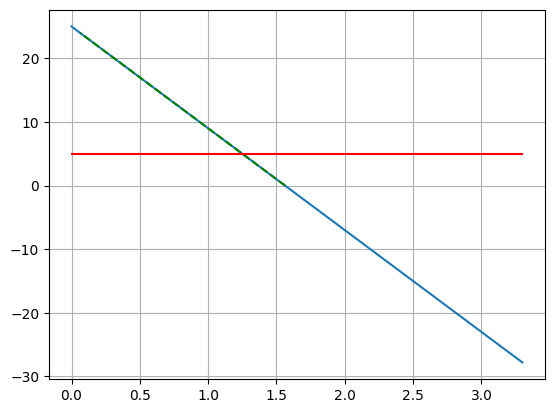

c_uc = 1.562500 V
m_uc = -0.062500 V/V


In [6]:
# Step-up converter Voltage Devider design
import math
import numpy as np
import matplotlib.pyplot as plt

R1 = 10000
#R1 = 2200

#Resistor design for fixed voltage
#Uout = 1.25V * (1 + R2/R1) , voltage devider, acc. to datasheet
# -> R2/R1 = Uout/1.25V - 1
Uout = 28
R2_R1 = Uout/1.25 - 1
R2 = R2_R1*R1
print('R_2fixed = {:.1f} kOhm'.format(R2/1000))

#Resistor design for variable voltage
#controllable by control voltage Uc
#e.g. Uc = 0.... 3.3V
#                   o Uout
#                   |
#                   R2
#                   |
#   Uc o----- Rc ---+----  1.25V (to Pin 5)
#                   |
#                   R1
#                   |
#                   _  0V
#
#
#   I_R1 = 1.25V / R1 = (Uout-1.25V)/R2 + (Uc-1.25V)/Rc
#  -> (Uout-1.25V)*R1/R2  + (Uc-1.25V)*R1/Rc = 1.25V
#  -> Uout = 1.25V * (1 + R2/R1 + R2/Rc) - Uc*R2/Rc
def U_out(R1,R2,Rc,Uc):
    Uout = 1.25 * (1 + R2/R1 + R2/Rc) - Uc*R2/Rc
    return Uout

#  Solve for Uc -> Uc = 1.25V*(1 + Rc/R1 + Rc/R2) -Rc/R2*Uout 
def U_c(R1,R2,Rc,Uout):
    Uc = 1.25 * (1 + Rc/R1 + Rc/R2) - Uout*Rc/R2
    return Uc
    

#   Uc = 0V -> Uout = Uout_max
#   Uc = Uc_mac (=3.3V) -> Uout = Uout_min
#   Uc = 1.25V -> Uout = Uout_uncontrolled
#   
#   ->    (Uout_max-1.25V)*R1_R2   +  (0V-1.25V)*R1_Rc = 1.25V
#   ->    (Uout_min-1.25V)*R1_R2   +  (Uc_max-1.25V)*R1_Rc = 1.25V
#   ->    (Uout_unctrld-1.25V)*R1_R2     + 0V         = 1.25V
Uout_max = 25
Uout_min = 5
Uc_max = 3.3
R_ratios_matrix = np.array([[Uout_max-1.25, 0-1.25],[Uout_min-1.25, Uc_max-1.25]])

# Variant to define via "uncontrolled" output voltage
Uout_unctrld = 5
R_ratios_matrix = np.array([[Uout_max-1.25, 0-1.25],[Uout_unctrld-1.25, 0]])

R_ratios_rightSide = np.array([1.25, 1.25])
[R1_R2, R1_Rc] = np.linalg.solve(R_ratios_matrix, R_ratios_rightSide)
R2 = R1/R1_R2
Rc = R1/R1_Rc
#print(R2)
#print(Rc)
print('R_1 = {:.1f} kOhm'.format(R1/1000))
print('R_2 = {:.1f} kOhm'.format(R2/1000))
print('R_c = {:.1f} kOhm'.format(Rc/1000))

Uc = np.arange(0, 3.3+0.1, 0.1)
Uout = U_out(R1, R2, Rc, Uc)

#Plausibility check
Uout_check = np.arange(0, 24+0.1, 0.1)
Uc_check = U_c(R1, R2, Rc, Uout_check)

plt.plot(Uc, Uout)
plt.plot(Uc_check, Uout_check, 'g--')
plt.plot(Uc, Uc*0 + 1.25*(1 + R2/R1), 'r-') #Output voltage without Uc
plt.grid()
plt.show()

print('c_uc = {:f} V'.format(1.25 * (1 + Rc/R1 + Rc/R2)))
print('m_uc = {:f} V/V'.format(-Rc/R2))



In [25]:
# Step-up converter Components design

import math

Uout = 28
#Uout = 5
Uf = 0.7 #Diode forward voltage
Uin_min = 2.8
Usat = 1.0

Iout_max = 0.1

fs = 40000
Ts = 1/fs

ton_toff = (Uout + Uf - Uin_min)/(Uin_min-Usat)
t_off = Ts / (ton_toff+1)
t_on = Ts-t_off

#print(ton_toff)
#print(t_on)
#print(t_off)
#print(Ts)
Ct = 4e-5*t_on
Isw_pk = 2*Iout_max * (ton_toff+1)
R_sc = 0.3/Isw_pk             #300mV voltage drop
L_min = (Uin_min-Usat)/Isw_pk * t_on

print('T_on = {:.1f}us'.format(t_on*1e6))
print('C_t = {:.0f}pF'.format(Ct*1e12))
print('Isw_pk = {:.2f}A'.format(Isw_pk))
print('R_sc = {:.3f}Ohms'.format(R_sc))
print('L_min = {:.2f}uH'.format(L_min*1e6))

T_on = 23.4us
C_t = 935pF
Isw_pk = 3.08A
R_sc = 0.097Ohms
L_min = 13.67uH
